# Annotation Analysis and Consensus

## Imports

In [2]:
# Standard imports
import numpy as np
import scipy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# ML Imports
from sklearn.metrics import cohen_kappa_score, f1_score, matthews_corrcoef
import statsmodels.formula.api as smf
from statannotations.Annotator import Annotator



# OS imports
from os.path import join as ospj
from os.path import exists as ospe
import sys

from ieeg.auth import Session
from utils import load_config, clean_labels, remove_scalp_electrodes, cohens_d, get_rpath, surgical_parcellation
sys.path.append('/users/wojemann/iEEG_processing')

import os

In [3]:
usr,passpath,datapath,prodatapath,metapath,figpath,patient_table,rid_hup,pt_list = load_config(ospj('/mnt/leif/littlab/users/wojemann/stim-seizures/code','config.json'))

In [4]:
plt.rcParams['image.cmap'] = 'magma'

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2

plt.rcParams['xtick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['ytick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['xtick.minor.size'] = 3   # Change to your desired minor tick size
plt.rcParams['ytick.minor.size'] = 3   # Change to your desired minor tick size

plt.rcParams['xtick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['ytick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['xtick.minor.width'] = 1  # Change to your desired minor tick width
plt.rcParams['ytick.minor.width'] = 1  # Change to your desired minor tick width
pal = sns.color_palette('Set2')[:2][::-1] + ['grey']

## Workspace Preparation

In [5]:
# Loading seizure onset meta data
sz_metadata = pd.read_csv(ospj(metapath,'stim_seizure_information - LF_seizure_annotation.csv'))
sz_metadata.drop(['Notes','Summaries'],axis=1,inplace=True)
# sz_metadata.replace({np.nan:pd.NA},inplace=True)

In [6]:
def combine_ch_annots(group):
    ret = {"clinician": [],
           "patient": [],
           "ueo": [],
           "ueo_time": [],
           "sec": []
          }
    # Sorting seizure annotations by clinician
    group.sort_values(by='Clinician',inplace=True)
    # Unifying and extracting iEEG name
    group['IEEGname'] = group['IEEGname'].fillna(method='ffill').fillna(method='bfill')
    ieeg_name = group['IEEGname'].iloc[0]
    pt = group['Patient'].iloc[0]
    # Get all channels from iEEG portal
    with open('woj_ieeglogin.bin', 'r') as f:
        session = Session('wojemann', f.read())
    ds = session.open_dataset(ieeg_name)
    # Clean channel labels
    raw_labels = clean_labels(ds.get_channel_labels(),pt)
    # Remove scalp electrodes from channels
    all_chs = remove_scalp_electrodes(raw_labels)

    for _,row in group.iterrows(): # for each annotation in seizure
        for i,v in row.items(): # for each column in annotation
            if not isinstance(v,list): # filling in nan's as empty list to ensure formatting consistency
                if pd.isna(v):
                    row[i] = []
        # Adding anntotor and patient data
        ret["clinician"].append(row.Clinician)
        ret["patient"] = row.Patient
        # Adding UEO and Spread channel ifnormation
        ret["ueo"].append([l in clean_labels(row.UEO_ch,pt) for l in all_chs])
        ret["sec"].append([l in clean_labels(row["10sec_ch"],pt) for l in all_chs])
        # Adding anntotated start time
        ret["ueo_time"].append(float(row.UEO_time))
        
    # Adding in additional patient metadata to table from originnal stim seizure metadata
    ret["all_chs"] = all_chs
    ret["iEEG_ID"] = row["IEEGname"]
    ret["approximate_onset"] = row["approximate_onset"]
    ret["offset"] = row["end"]
    ret["stim"] = row["stim"]
        
    return pd.Series(ret)

def create_consensus(row):
    for key in ["ueo","sec"]:
        row[f"{key}_consensus"] = np.array(np.sum(np.array(row[key]).astype(int),axis=0) >= (len(row[key])/2)).astype(bool)
        row[f"{key}_any"] = np.array(np.sum(np.array(row[key]).astype(int),axis=0) >= 1).astype(bool)
        if key == 'ueo':
            row[f"{key}_time_consensus"] = np.median(row[f"{key}_time"])
    return row

## Seizure Annotator Analysis

### Preparing annotation table

In [5]:
annotators = np.sort(['EC','CK','DZ','JJ','JK']) # annotator list
time_labels = ['UEO_time'] # onset time label
clinician_tables = {}
for clin in annotators:
    # Load in secondary annotation push
    annot_table = pd.read_csv(ospj(metapath,f"stim_seizure_annotations_{clin}.csv"))
    # Load in annotations from initial assessment
    demo_table = pd.read_csv(ospj(metapath,f"stim_seizure_information - {clin}_annotation_demo.csv"))
    # Unifying onset column name
    demo_table.columns = [c if c != 'Onset' else 'approximate_onset' for c in demo_table.columns]
    # Aggregating tables across clinicians and annotation sections
    clinician_tables[clin] = []
    clinician_tables[clin].append(annot_table)
    clinician_tables[clin].append(demo_table)
# Organizing dataframes into a list for concatenation
df_list = [df for l in clinician_tables.values() for df in l]
# Getting annotator key for each DF
key_list = np.array([[key]*2 for key in clinician_tables.keys()]).flatten()

# Combining DFs
combined_df = pd.concat(df_list, keys=key_list, names=['Clinician'])

# Reset index to avoid having MultiIndex
combined_df.reset_index(inplace=True)

# Drop nan rows from csv loading
combined_df = combined_df.dropna(axis=0,how='any',subset=['UEO_ch'])

# Create a unique identifier for each seizure
combined_df['Seizure_ID'] = combined_df.groupby(['Patient', 'Clinician']).cumcount() + 1
combined_df['Seizure_ID'] = combined_df['Patient'] + '_' + combined_df['Seizure_ID'].astype(int).astype(str)
combined_df = combined_df.drop(['level_1'],axis=1)

# Turning strings of channels to a list
combined_df['UEO_ch'] = combined_df['UEO_ch'].str.split(',')
combined_df['10sec_ch'] = combined_df['10sec_ch'].str.split(',')

In [ ]:
# Applying function to combine channel annotations across annotators to get one row per seizure
combined_annots = combined_df.groupby('Seizure_ID').apply(combine_ch_annots).reset_index()

In [ ]:
# Removing seizures if a clinician did not think it was sufficiently a seizure
combined_annots_reduced = combined_annots[combined_annots.clinician.apply(lambda x: len(x)) > 2]
combined_annots_reduced.head()

### Calculating clinician kappas

In [ ]:
# Calculate the kappa value between each pair of clinicians for each seizure
def pairwise_kappa(row):
    row_idxs = [i for i in row.index if i in ["ueo","sec"]] # extracting indices for annotations
    for ch_type in row_idxs:
        all_kappas = np.ones((len(row[ch_type]),len(row[ch_type])))*2 # initializing kappas
        all_dice = np.ones((len(row[ch_type]),len(row[ch_type])))*2
        chs = row[ch_type] # getting list of all annotations for that seizure and annot type
        for i in range(len(chs)): # getting first annotator
            for j in range(i+1,len(chs)): # getting second annotator
                all_kappas[i,j] = f1_score(chs[i],chs[j]) # calculating agreement
                all_dice[i,j] = f1_score(chs[i],chs[j])
                if ch_type == 'ueo': # adding to collection for plotting
                    ANNOT_ALL_SZ[row.clinician[i]].append(all_kappas[i,j])
                    ANNOT_ALL_SZ[row.clinician[j]].append(all_kappas[i,j])
        # # optional code to plot a heat-map per seizure
        # plt.figure()
        # sns.heatmap(all_kappas,annot=True,fmt=".2f",cmap="magma",xticklabels=row.clinician,yticklabels=row.clinician,vmin=0,vmax=1)
        # plt.title(f"{row.name}: {ch_type}")
        # Assigning kappas matrix for that seizure and annot type
        row[f"{ch_type}_kappas"] = all_kappas

    return row

In [10]:
# Function for plotting the agreement that each clinician has with the other clinicians on average
def plot_kappas_by_clinician(ANNOT_ALL_SZ):
    max_length = max(len(arr) for arr in ANNOT_ALL_SZ.values())
    for key in ANNOT_ALL_SZ.keys():
        ANNOT_ALL_SZ[key] += [np.nan] * (max_length - len(ANNOT_ALL_SZ[key]))
    plotting_df = pd.DataFrame.from_dict(ANNOT_ALL_SZ).melt()
    sns.boxplot(plotting_df,x='variable',y='value',palette='flare')
    # plt.xticks(np.arange(len(annotators)),annotators)
    plt.title("UEO Cohen's Kappa by Annotator")
    plt.ylabel('Cohen\'s Kappa')
    plt.xlabel('Clinician Annotator')

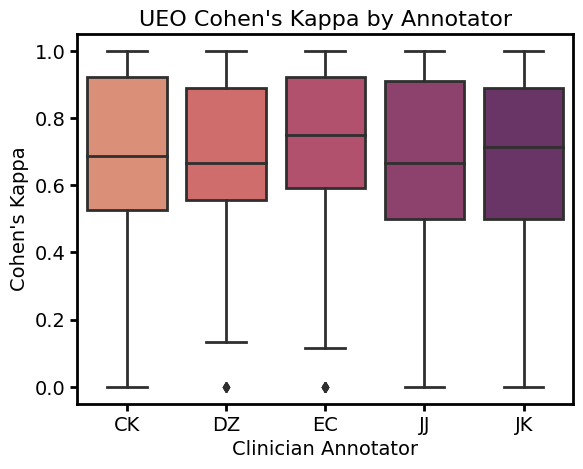

In [11]:
# All
ANNOT_ALL_SZ = {i:[] for i in annotators}
kappa_annots = combined_annots_reduced.apply(pairwise_kappa,axis=1).reset_index(drop=True)
plot_kappas_by_clinician(ANNOT_ALL_SZ)

0.6181256126195523 0.23762968771025278
0.6221326670352404 0.22179744116691047


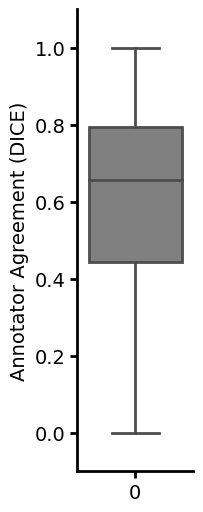

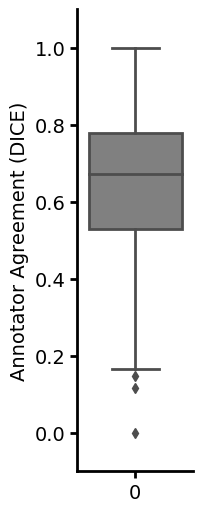

In [13]:
data = []
for i in range(len(kappa_annots)):
    mat = kappa_annots[['ueo_kappas']].iloc[i,0]
    val = np.nanmean([k if k != 2 else np.nan for k in mat.flatten()])
    data.append(val)
data = np.array(data)
print(np.mean(data),np.std(data))
np.save(ospj(prodatapath,"ueo_annotator_dist.npz"),data)
plt.figure(figsize=(1.5,6))
plt.tight_layout()
sns.boxplot(data,color='grey')
plt.ylabel('Annotator Agreement (DICE)')
plt.ylim([-.1,1.1])
sns.despine()
plt.savefig(ospj(figpath,'all_annotator_ueo_dice.pdf'),bbox_inches='tight')
data = []
for i in range(len(kappa_annots)):
    mat = kappa_annots[['sec_kappas']].iloc[i,0]
    val = np.nanmean([k if k != 2 else np.nan for k in mat.flatten()])
    data.append(val)
data = np.array(data)
print(np.mean(data),np.std(data))
np.save(ospj(prodatapath,"sec_annotator_dist.npz"),data)
plt.figure(figsize=(1.5,6))
plt.tight_layout()
sns.boxplot(data,color='grey')
plt.ylabel('Annotator Agreement (DICE)')
plt.ylim([-.1,1.1])
sns.despine()
plt.savefig(ospj(figpath,'all_annotator_sec_dice.pdf'),bbox_inches='tight')

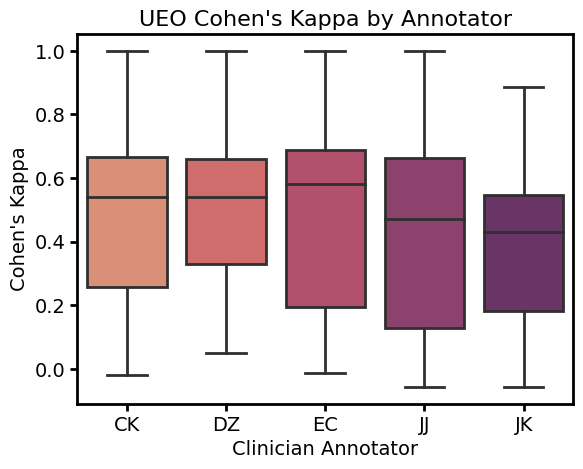

In [ ]:
# CHOP
ANNOT_ALL_SZ = {i:[] for i in annotators}
kappa_annots_chop = combined_annots_reduced[combined_annots_reduced.patient.apply(lambda x: x[:-3]) == 'CHOP'].apply(pairwise_kappa,axis=1).reset_index(drop=True)
plot_kappas_by_clinician(ANNOT_ALL_SZ)

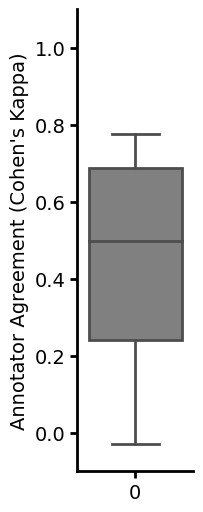

In [ ]:
data = []
for i in range(len(kappa_annots_chop)):
    mat = kappa_annots_chop[['ueo_kappas']].iloc[i,0]
    val = np.nanmean([k if k != 2 else np.nan for k in mat.flatten()])
    data.append(val)
data = np.array(data)
plt.figure(figsize=(1.5,6))
plt.tight_layout()
sns.boxplot(data,color='grey')
plt.ylabel('Annotator Agreement (Cohen\'s Kappa)')
plt.ylim([-.1,1.1])
sns.despine()
plt.savefig(ospj(figpath,'all_annotator_ueo_kappa_chop.pdf'),bbox_inches='tight')

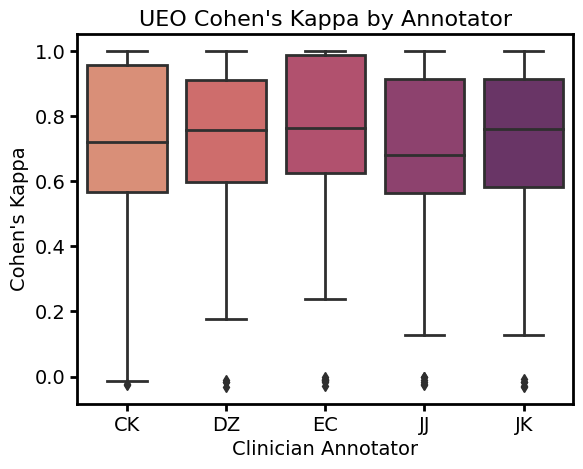

In [ ]:
# HUP
ANNOT_ALL_SZ = {i:[] for i in annotators}
kappa_annots_hup = combined_annots_reduced[combined_annots_reduced.patient.apply(lambda x: x[:-3]) != 'CHOP'].apply(pairwise_kappa,axis=1).reset_index(drop=True)
plot_kappas_by_clinician(ANNOT_ALL_SZ)

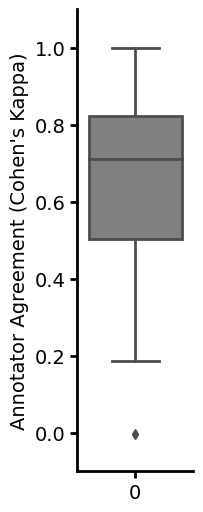

In [ ]:
data = []
for i in range(len(kappa_annots_hup)):
    mat = kappa_annots_hup[['ueo_kappas']].iloc[i,0]
    val = np.nanmean([k if k != 2 else np.nan for k in mat.flatten()])
    data.append(val)
data = np.array(data)
plt.figure(figsize=(1.5,6))
plt.tight_layout()
sns.boxplot(data,color='grey')
plt.ylabel('Annotator Agreement (Cohen\'s Kappa)')
plt.ylim([-.1,1.1])
sns.despine()
plt.savefig(ospj(figpath,'all_annotator_ueo_kappa_hup.pdf'),bbox_inches='tight')

### Calculating seizure level agreement

In [ ]:
def sz_level_agreement(row):
    row_idxs = [i for i in row.index if 'kappas' in i]
    for chtype in row_idxs:
        row[f"{chtype[:-7]}_avg"] = np.mean(row[chtype][row[chtype] != 2])
    return row
kappa_avg = kappa_annots.apply(sz_level_agreement,axis=1)
kappa_avg.head()

,Seizure_ID,clinician,patient,ueo,ueo_time,sec,all_chs,iEEG_ID,approximate_onset,offset,stim,ueo_kappas,sec_kappas,ueo_avg,sec_avg
0,CHOP005_1,"[CK, JJ, JK]",CHOP005,"[[False, False, False, False, False, False, Fa...","[68881.44, 68881.52, 68881.26]","[[False, False, False, False, False, False, Fa...","[LA01, LA10, LA02, LA03, LA04, LA05, LA06, LA0...",CHOP005,68881.53,68944.57,1.0,"[[2.0, 0.7443820224719101, 0.6583229036295369]...","[[2.0, 0.42435424354243545, 0.5687203791469194...",0.762938,0.507339
1,CHOP010_1,"[DZ, EC, JK]",CHOP010,"[[False, False, False, False, False, False, Fa...","[2232.773277, 2232.6, 2232.77]","[[False, False, False, False, False, False, Fa...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",CHOPCCEP_010,2230.26,2267.78,1.0,"[[2.0, 0.18894009216589858, 0.5230352303523036...","[[2.0, 0.17039106145251393, 0.7622478386167147...",0.232717,0.354422
2,CHOP015_1,"[CK, JJ, JK]",CHOP015,"[[False, False, False, False, False, False, Fa...","[77180.36, 77180.95, 77190.4]","[[False, False, False, False, False, False, Fa...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",CHOPCCEP_015,77190.79,77225.07,1.0,"[[2.0, -0.014084507042253724, -0.0152284263959...","[[2.0, 0.5, 0.5473251028806584], [2.0, 2.0, 0....",-0.028639,0.515775
3,CHOP015_2,"[CK, JJ, JK]",CHOP015,"[[False, False, False, False, False, False, Fa...","[81584.13, 81587.68, 81587.23]","[[False, False, False, True, True, False, Fals...","[LA01, LA02, LA03, LA04, LA05, LA06, LA07, LA0...",CHOPCCEP_015,81585.72,81614.99,0.0,"[[2.0, 1.0, 0.3918918918918919], [2.0, 2.0, 0....","[[2.0, 0.4744525547445255, 0.7567567567567568]...",0.594595,0.530466
4,CHOP024_1,"[CK, DZ, JJ]",CHOP024,"[[False, False, False, False, False, False, Fa...","[87577.58, 875775.9034, 87576.74]","[[False, False, False, False, False, False, Fa...","[LA01, LA10, LA02, LA03, LA04, LA05, LA06, LA0...",CHOPCCEP_024,87579.25,87591.61,1.0,"[[2.0, 0.48051948051948057, -0.020408163265306...","[[2.0, nan, nan], [2.0, 2.0, nan], [2.0, 2.0, ...",0.268635,NaN


Text(0.5, 1.0, "Average Channel Agreement (Cohen's Kappa) per Seizure")

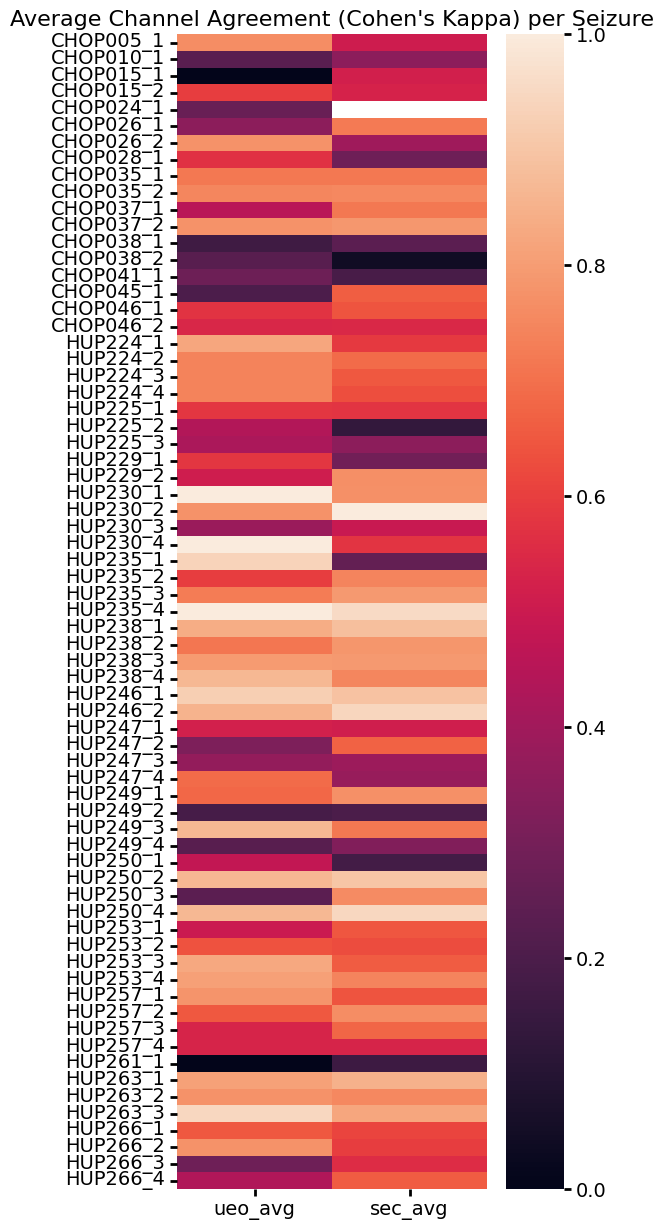

In [ ]:
fig,ax = plt.subplots(figsize=(5,15))
# fig.figsize = (15,5)
sns.heatmap(kappa_avg.iloc[:,-2:],yticklabels=kappa_avg.Seizure_ID,vmin=0,vmax=1)
plt.title("Average Channel Agreement (Cohen\'s Kappa) per Seizure")

### Creating clinician consensus

In [12]:
def create_consensus(row):
    for key in ["ueo","sec"]:
        row[f"{key}_consensus"] = np.array(np.sum(np.array(row[key]).astype(int),axis=0) >= (len(row[key])/2)).astype(bool)
        row[f"{key}_any"] = np.array(np.sum(np.array(row[key]).astype(int),axis=0) >= 1).astype(bool)
        if key == 'ueo':
            row[f"{key}_time_consensus"] = np.median(row[f"{key}_time"])
    return row

In [ ]:
consensus_annots = combined_annots.apply(create_consensus,axis=1)
consensus_annots.head()

In [ ]:
# consensus_annots.to_csv(ospj(prodatapath,"stim_seizure_information_consensus.csv"),index=False)
# consensus_annots.to_pickle(ospj(prodatapath,"stim_seizure_information_consensus.pkl"))

## Manual annotation analysis

In [6]:
consensus_annots = pd.read_pickle(ospj(prodatapath,"threshold_tuning_consensus_v2.pkl"))
consensus_annots = consensus_annots.sort_values('approximate_onset')
seizures_df = pd.read_csv(ospj(metapath,"stim_seizure_information - LF_seizure_annotation.csv"))
seizures_df.dropna(axis=0,how='all',inplace=True)
seizures_df.rename(columns=dict(Patient='patient',IEEGname='iEEG_ID'),inplace=True)
seizures_df['approximate_onset'].fillna(seizures_df['UEO'],inplace=True)
seizures_df['approximate_onset'].fillna(seizures_df['EEC'],inplace=True)
seizures_df['approximate_onset'].fillna(seizures_df['Other_onset_description'],inplace=True)
# drop HF stim induced seizures
seizures_df = seizures_df[seizures_df.stim != 2]
seizures_df.sort_values('approximate_onset',inplace=True)

In [7]:
consensus_annots = pd.merge_asof(consensus_annots,
            seizures_df[['approximate_onset','patient',"iEEG_ID","typical","stim_channels"]],
            on='approximate_onset',by=['patient','iEEG_ID'],
            tolerance = 240,
            direction='nearest')

In [8]:
print(len(consensus_annots.patient.unique()),len(consensus_annots.Seizure_ID.unique()))
print(consensus_annots.stim.sum().astype(int))

33 87
40


In [9]:
def calculate_seizure_similarity(annots,first_annot = 'ueo_consensus', second_annot = 'ueo_consensus',paired=True):
    annot_list = ["kappa","F1","MCC","patient","spont","typical"]
    annot_dict = {key:[] for key in annot_list}
    skip_pt = []
    for pt,group in annots.groupby("patient"):
        if (sum(group.stim == 0) < 2) and paired:
            skip_pt.append(pt)
            continue
        elif len(group) < 2:
            skip_pt.append(pt)
            continue
        # Iterate through each seizure
        for i in range(len(group)):
            group.reset_index(drop=True,inplace=True)
            ch_mask = group.loc[i,first_annot].reshape(-1)
            for j in range(i+1,len(group)):
                if (group.loc[i,'stim'] == 1)  and (group.loc[j,'stim'] == 1): # skip both stim
                    continue
                ch_mask2 = group.loc[j,second_annot].reshape(-1)
                annot_dict["kappa"].append(cohen_kappa_score(ch_mask,ch_mask2))
                annot_dict["F1"].append(f1_score(ch_mask,ch_mask2))
                annot_dict["MCC"].append(matthews_corrcoef(ch_mask,ch_mask2))
                annot_dict["spont"].append(not ((group.loc[i,'stim'] == 1)  or (group.loc[j,'stim'] == 1)))
                # want to append a boolean that will tell me if one sz is stim and one sz is typical
                annot_dict["typical"].append(((group.loc[i,'typical'] == 1)  
                                                        or (group.loc[j,'typical'] == 1)))
                annot_dict["patient"].append(pt)
    annot_df = pd.DataFrame(annot_dict)
    print(f"Skipped {skip_pt} due to insufficient spontaneous seizures")
    return annot_df

def calculate_spread_similarity(annots,first_annot = 'sz_chs', second_annot = 'sz_chs', sources = 'all_channels', spread_thresh = 30, paired=True):
    annot_list = ["MCC","Rank","patient","spont","typical"]
    annot_dict = {key:[] for key in annot_list}
    skip_pt = []
    for pt,group in annots.groupby("patient"):
        if (sum(group.stim == 0) < 2) and paired:
            skip_pt.append(pt)
            continue
        elif len(group) < 2:
            skip_pt.append(pt)
            continue
        # Iterate through each seizure
        for i in range(len(group)):
            group.reset_index(drop=True,inplace=True)
            # for each channel in sz_chs, is the time in sz_times less than spread_thresh, and if so set that channel to true
            ch_time_mask = [t < spread_thresh for t in group.loc[i,'sz_times']]
            if len(ch_time_mask) == 0:
                continue
            ch_mask = np.isin(group.loc[i,sources],group.loc[i,first_annot][ch_time_mask])

            onset_dict = dict(zip(group.loc[i,first_annot],group.loc[i,'sz_times']))
            max_latency = group.loc[i,'sz_times'].max() + 1
            all_latencies = np.array([onset_dict.get(ch,max_latency) for ch in group.loc[i,sources]])

            for j in range(i+1,len(group)):
                if (group.loc[i,'stim'] == 1)  and (group.loc[j,'stim'] == 1): # skip both stim
                    continue
                ch_time_mask2 = [t < spread_thresh for t in group.loc[j,'sz_times']]
                if len(ch_time_mask2) == 0:
                    continue
                ch_mask2 = np.isin(group.loc[j,sources],group.loc[j,first_annot][ch_time_mask2])
                onset_dict2 = dict(zip(group.loc[j,first_annot],group.loc[j,'sz_times']))
                max_latency2 = group.loc[j,'sz_times'].max() + 1
                all_latencies2 = np.array([onset_dict2.get(ch,max_latency2) for ch in group.loc[j,sources]])

                annot_dict["MCC"].append(matthews_corrcoef(ch_mask,ch_mask2))
                annot_dict["Rank"].append(sc.stats.spearmanr(all_latencies,all_latencies2).statistic)
                annot_dict["spont"].append(not ((group.loc[i,'stim'] == 1)  or (group.loc[j,'stim'] == 1)))

                # want to append a boolean that will tell me if one sz is stim and one sz is typical
                annot_dict["typical"].append(((group.loc[i,'typical'] == 1)  
                                                        or (group.loc[j,'typical'] == 1)))
                annot_dict["patient"].append(pt)
    annot_df = pd.DataFrame(annot_dict)
    print(f"Skipped {skip_pt} due to insufficient spontaneous seizures")
    return annot_df

def plot_seizure_similarity(dat,agreement='MCC',palette=['red','blue','purple'],annot_type='',
                            sz_level=True, binary = False, typical = None, combiner = 75,
                            annot_stats=True):
    if typical is not None:
        all_groups = []
        for _, group in dat.groupby(['patient']):
            stims = group.loc[(group.spont==False) & (group.typical == typical),:]

            if len(stims) == 0:
                continue
            
            all_groups.append(pd.concat([stims,group.loc[group.spont,:]],axis=0))

        dat = pd.concat(all_groups, axis=0)


    def percentile(x,combiner=combiner):
        return np.percentile(x,combiner,method='nearest')
        # return np.mean(x)


    # Define the aggregation functions
    numeric_cols = dat.select_dtypes(include='number').columns
    non_numeric_cols = dat.select_dtypes(exclude='number').columns.difference(['patient', 'spont'])
    

    if (agreement == 'Rank'):
        dat['Rank'] = dat['Rank'].fillna(0)
        # dat = dat[~dat.isna().any(axis=1)]

    pt_data = dat.groupby(['patient', 'spont']).agg(
        {col: percentile for col in numeric_cols} |
        {col: 'max' for col in non_numeric_cols}
    ).reset_index()

    # pt_data = data.groupby(["patient","spont"])[["kappa","F1"]].apply(agg_funcs).reset_index()
    fig,ax = plt.subplots(figsize=(4,5))
    if sz_level:
        model = smf.mixedlm(f"{agreement} ~ C(spont)", dat, groups="patient")
        result = model.fit()
        print(result.summary())
        print(result.pvalues)
        plot_data = dat
        # plt.title(f"Seizure-Level Seizure{annot_type} Similarity")

    else:
        plot_data = pt_data
        _,p = sc.stats.wilcoxon(pt_data[~pt_data.spont].sort_values('patient')[agreement],pt_data[pt_data.spont].sort_values('patient')[agreement])
        if binary:
            cont = pd.crosstab(pt_data.spont,pt_data[agreement])
            res = sc.stats.chi2_contingency(cont)
            p = res.pvalue
            print(res)
            fig1,ax1 = plt.subplots()
            sns.heatmap(cont,annot=True,robust=True,
                        xticklabels=True,yticklabels=True,
                        cmap=sns.light_palette("seagreen", as_cmap=True),
                        ax=ax1,
                        cbar=False)
            ax1.set_yticks([0.5,1.5],["Stim-Spont","Spont-Spont"])
            ax1.set_xlabel("Region Agreement?")
            ax1.set_ylabel("")
            fig1.savefig(ospj(figpath,"one_onset_region_boxes.pdf"))
        d = cohens_d(pt_data[~pt_data.spont][agreement],pt_data[pt_data.spont][agreement])
        # print(f"Paired t-test - p: {p}, d: {d}")
        # ax.set_title(f"Patient-Level Seizure{annot_type} Similarity")

    ax = sns.pointplot(data=plot_data,x="spont",y=agreement,
                errorbar=None,
                markers="_",
                linestyles="none",
                palette=palette[:2],
                estimator=np.median,
                linewidth=4,
                markersize=45,
                ax=ax)
    # plt.setp(ax.lines, linewidth=20)
    sns.swarmplot(data=plot_data,x="spont",y=agreement,
                alpha=.5,
                palette = palette[:2],
                ax=ax
                # hue='patient'
                )
    if annot_stats:
        annotator = Annotator(ax,[(True,False)],data=plot_data,x='spont',y=agreement)
        annotator.configure(test='Wilcoxon',
        loc='outside',
        text_format='star',
        fontsize=14,
        pvalue_thresholds=[[1e-4, "****"], [1e-3, "***"],
                        [1e-2, "**"], [0.05, "*"], [0.1, "x"],[1, "ns"]])
        annotator.apply_and_annotate()

    plt.ylim([-0.25,1.15])
    sns.despine()
    ax.set_xticks([0,1],["Stim Induced","Spontaneous"])
    ax.set_xlabel('')
    ax.set_ylabel('Onset Similarity ($\phi$)')

    return fig

In [10]:
# def calculate_seizure_similarity(annots,first_annot = 'ueo_consensus', second_annot = 'ueo_consensus',paired=True):
#     annot_list = ["kappa","F1","patient","spont"]
#     annot_dict = {key:[] for key in annot_list}
#     skip_pt = []
#     for pt,group in annots.groupby("patient"):
#         if (sum(group.stim == 0) < 2) and paired:
#             skip_pt.append(pt)
#             continue
#         elif len(group) < 2:
#             skip_pt.append(pt)
#             continue
#         # Iterate through each seizure
#         for i in range(len(group)):
#             group.reset_index(drop=True,inplace=True)
#             ch_mask = group.loc[i,first_annot]
#             for j in range(i+1,len(group)):
#                 if (group.loc[i,'stim'] == 1)  and (group.loc[j,'stim'] == 1): # skip both stim
#                     continue
#                 ch_mask2 = group.loc[j,second_annot]
#                 annot_dict["kappa"].append(cohen_kappa_score(ch_mask,ch_mask2))
#                 annot_dict["F1"].append(f1_score(ch_mask,ch_mask2))
#                 annot_dict["spont"].append(not (group.loc[i,'stim'] == 1)  or (group.loc[j,'stim'] == 1))
#                 annot_dict["patient"].append(pt)
#     annot_df = pd.DataFrame(annot_dict)
#     print(f"Skipped {skip_pt} due to insufficient spontaneous seizures")
#     return annot_df

In [11]:
# def plot_seizure_similarity(data,agreement='F1',palette=['red','blue','purple'],annot_type='',sz_level=True):
#     def percentile_75(x):
#         return np.percentile(x,75)
#     # Define the aggregation functions
#     numeric_cols = data.select_dtypes(include='number').columns
#     non_numeric_cols = data.select_dtypes(exclude='number').columns.difference(['patient', 'spont'])

#     pt_data = data.groupby(['patient', 'spont']).agg(
#         {col: percentile_75 for col in numeric_cols} |
#         {col: 'max' for col in non_numeric_cols}
#     ).reset_index()

#     # pt_data = data.groupby(["patient","spont"]).max().reset_index()
#     pivoted = pt_data.pivot(index='patient', columns='spont', values=agreement).reset_index()
#     plt.figure(figsize=(4.5,5))
#     if sz_level:
#         model = smf.mixedlm("F1 ~ C(spont)", data, groups="patient")
#         result = model.fit()
#         print(result.summary())
#         print(result.pvalues)

#         plot_data = data
#         plt.title(f"Seizure-Level Seizure{annot_type} Similarity")

#     else:
#         plot_data = pt_data
#         _,p = sc.stats.ttest_ind(pt_data[~pt_data.spont][agreement],pt_data[pt_data.spont][agreement])
#         d = cohens_d(pt_data[~pt_data.spont][agreement],pt_data[pt_data.spont][agreement])
#         print(f"Wilcoxon test - p: {p}, d: {d}")
#         plt.title(f"Patient-Level Seizure{annot_type} Similarity")

                
#     ax = sns.pointplot(data=plot_data,x="spont",y=agreement,errorbar=None,
#                 markers="_",linestyles="none",palette=palette[:2],
#                 estimator='median',
#                 legend=False,
#                 markersize=45,
#                 linewidth=4)
#     plt.setp(ax.collections, sizes=[1000])
#     sns.swarmplot(data=plot_data,
#                 x="spont",
#                 y=agreement,
#                 alpha=.7,
#                 palette = palette[:2],
#                 hue='spont',
#                 legend=False
#                 )
#     # plt.plot(pivoted.iloc[:,-2:].T,color=palette[2],alpha=.2)
#     sns.despine()
#     plt.xticks([0,1],["Stimulation Induced","Spontaneous"])
#     plt.xlabel('')
#     plt.ylabel(f"Seizure Agreement ({agreement})")
    

### Channels

#### Stim seizures localizing onset

Skipped ['CHOP005', 'CHOP010', 'CHOP015', 'CHOP024', 'CHOP026', 'CHOP028', 'CHOP035', 'CHOP037', 'CHOP038', 'CHOP041', 'CHOP044', 'CHOP045', 'CHOP046', 'CHOP049', 'HUP229', 'HUP246', 'HUP261', 'HUP267', 'HUP273', 'HUP275', 'HUP288'] due to insufficient spontaneous seizures
p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       x: 5.00e-02 < p <= 1.00e-01
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Wilcoxon test (paired samples), P_val:5.046e-02 Stat=1.100e+01


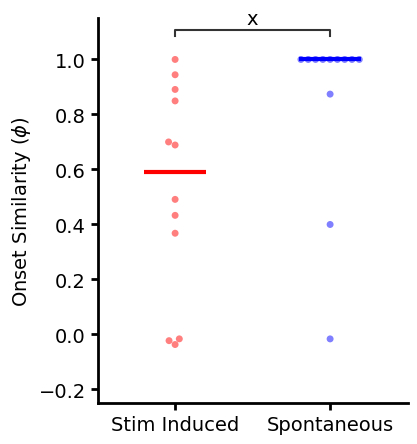

In [12]:
channel_onset_df = calculate_seizure_similarity(consensus_annots)
agreement='MCC'
# print(sc.stats.mannwhitneyu(channel_onset_df[channel_onset_df.spont == True][agreement],channel_onset_df[channel_onset_df.spont == False][agreement]))
# print(cohens_d(channel_onset_df[channel_onset_df.spont == False][agreement],channel_onset_df[channel_onset_df.spont == True][agreement]))
_ = plot_seizure_similarity(channel_onset_df,annot_type=' Onset',sz_level=False)
plt.savefig(ospj(figpath,"clin_ch_sz_similarity.pdf"),bbox_inches='tight')

In [13]:
channel_onset_df.patient.nunique()

12

In [11]:
# channel_onset_df = calculate_seizure_similarity(consensus_annots,paired=True)
# plt.figure(figsize=(4.5,5))
# agreement = "F1"
# ax = sns.pointplot(data=channel_onset_df,x="spont",y=agreement,errorbar=None,
#               markers="_",linestyles="none",palette=["red","blue"],
#               estimator='median')
# plt.setp(ax.collections, sizes=[1000])
# sns.stripplot(data=channel_onset_df,x="spont",y=agreement,palette = ['red','blue'],alpha=.2)

# sns.despine()
# plt.xticks([0,1],["Stimulation Induced","Spontaneous"])
# plt.xlabel('')
# plt.ylabel(f"Average Agreement ({agreement})")
# plt.title(f"Average Seizure-Level Seizure Onset Channel Similarity")
# print(sc.stats.mannwhitneyu(channel_onset_df[channel_onset_df.spont == True][agreement],channel_onset_df[channel_onset_df.spont == False][agreement]))
# print(cohens_d(channel_onset_df[channel_onset_df.spont == False][agreement],channel_onset_df[channel_onset_df.spont == True][agreement]))

#### Stim seizures localizing spread channels

Skipped ['CHOP005', 'CHOP010', 'CHOP015', 'CHOP024', 'CHOP026', 'CHOP028', 'CHOP035', 'CHOP037', 'CHOP038', 'CHOP041', 'CHOP044', 'CHOP045', 'CHOP046', 'CHOP049', 'HUP229', 'HUP246', 'HUP261', 'HUP267', 'HUP273', 'HUP275', 'HUP288'] due to insufficient spontaneous seizures
p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       x: 5.00e-02 < p <= 1.00e-01
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Wilcoxon test (paired samples), P_val:5.937e-01 Stat=2.700e+01


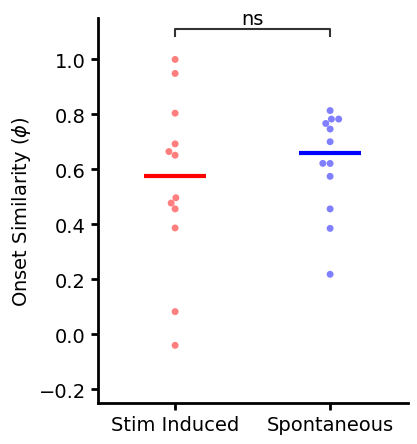

In [12]:
channel_onset_df = calculate_seizure_similarity(consensus_annots,second_annot='sec_consensus')
_ = plot_seizure_similarity(channel_onset_df,annot_type=' Spread',sz_level=False)

In [13]:
# channel_spread_df = calculate_seizure_similarity(consensus_annots,paired=True,second_annot='sec_consensus')
# plt.figure(figsize=(4.5,5))
# agreement = "F1"
# ax = sns.pointplot(data=channel_spread_df,x="spont",y=agreement,errorbar=None,
#               markers="_",linestyles="none",palette=["red","blue"],
#               estimator='median')
# plt.setp(ax.collections, sizes=[1000])
# sns.stripplot(data=channel_spread_df,x="spont",y=agreement,palette = ['red','blue'],alpha=.2)

# sns.despine()
# plt.xticks([0,1],["Stimulation Induced","Spontaneous"])
# plt.xlabel('')
# plt.ylabel(f"Average Agreement ({agreement})")
# plt.title(f"Average Seizure-Level Seizure Onset Channel Similarity")
# print(sc.stats.mannwhitneyu(channel_spread_df[channel_spread_df.spont == True][agreement],channel_spread_df[channel_spread_df.spont == False][agreement]))
# print(cohens_d(channel_spread_df[channel_spread_df.spont == False][agreement],channel_spread_df[channel_spread_df.spont == True][agreement]))

### Regions

#### Annotating Onsets

In [14]:
annotations_df = pd.read_pickle(ospj(prodatapath,"stim_seizure_information_consensus.pkl"))
annotations_df.sort_values('approximate_onset',inplace=True)
pt_groups = consensus_annots.groupby('patient')
for pt,group in pt_groups:
    region_path = get_rpath(prodatapath,pt)
    if not ospe(region_path):
        continue
    electrode_regions = pd.read_pickle(region_path)
    electrode_regions = surgical_parcellation(electrode_regions)
    for idx,row in group.iterrows():
        consensus_annots.at[idx,'all_rs'] = np.array(electrode_regions[electrode_regions.name.isin(row['all_chs'])]['label'].unique())
        for col in ['ueo_consensus','ueo_any','sec_consensus','sec_any']:
            chs = np.array(row.all_chs)[row[col]]
            electrode_locals = np.array([l for l in electrode_regions[electrode_regions.name.isin(chs)]['label'].unique() if l != 'EmptyLabel'])
            consensus_annots.at[idx,col+'_rs'] = np.array([l in electrode_locals for l in consensus_annots.loc[idx,'all_rs']])
        # annotations_df.at[idx,'all_rs'] = electrode_regions[electrode_regions.name.isin(row['all_chs'])]['label'].unique()
consensus_annots_rs = consensus_annots.dropna(axis=0,subset='ueo_consensus_rs')
consensus_annots_rs.sort_values(['patient','iEEG_ID','approximate_onset'],inplace=True)

Skipped ['CHOP005', 'CHOP024', 'CHOP026', 'CHOP028', 'CHOP035', 'CHOP037', 'CHOP041', 'CHOP044', 'CHOP045', 'CHOP049', 'HUP229', 'HUP246', 'HUP261', 'HUP267', 'HUP273', 'HUP275', 'HUP288'] due to insufficient spontaneous seizures
p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       x: 5.00e-02 < p <= 1.00e-01
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Wilcoxon test (paired samples), P_val:4.428e-01 Stat=9.500e+00


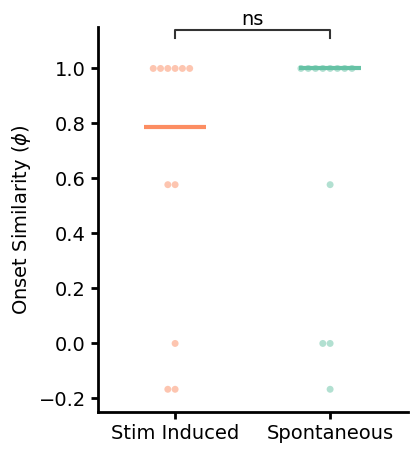

In [15]:
channel_onset_df = calculate_seizure_similarity(consensus_annots_rs,first_annot='ueo_consensus_rs',second_annot='ueo_consensus_rs')
_ = plot_seizure_similarity(channel_onset_df,annot_type=' Onset',palette=pal,agreement='MCC',sz_level=False)
plt.savefig(ospj(figpath,"clin_region_sz_similarity.pdf"),bbox_inches='tight')

p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       x: 5.00e-02 < p <= 1.00e-01
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Wilcoxon test (paired samples), P_val:4.652e-01 Stat=3.000e+00


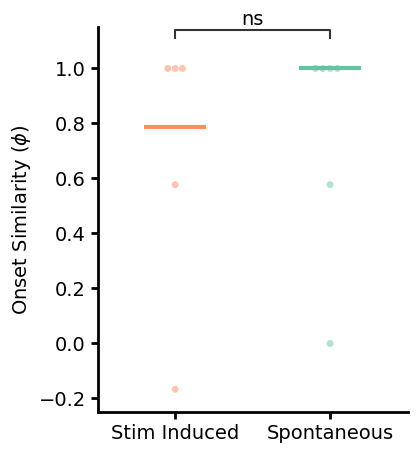

In [17]:
_ = plot_seizure_similarity(channel_onset_df,annot_type=' Onset',palette=pal,agreement='MCC',sz_level=False,typical=1)
plt.savefig(ospj(figpath,"clin_region_sz_similarity_typical.pdf"),bbox_inches='tight')

p-value annotation legend:
      ns: 1.00e-01 < p <= 1.00e+00
       x: 5.00e-02 < p <= 1.00e-01
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Wilcoxon test (paired samples), P_val:7.855e-01 Stat=2.500e+00


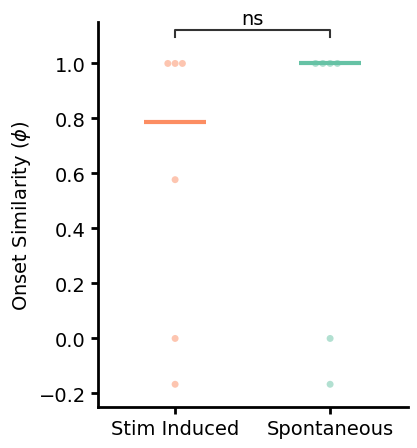

In [18]:
_ = plot_seizure_similarity(channel_onset_df,annot_type=' Onset',palette=pal,agreement='MCC',sz_level=False,typical=0)
plt.savefig(ospj(figpath,"clin_region_sz_similarity_atypical.pdf"),bbox_inches='tight')

#### Stim seizures localizing spread regions

Skipped ['CHOP005', 'CHOP024', 'CHOP026', 'CHOP028', 'CHOP035', 'CHOP037', 'CHOP041', 'CHOP044', 'CHOP045', 'CHOP049', 'HUP229', 'HUP246', 'HUP261', 'HUP267', 'HUP273', 'HUP275', 'HUP288'] due to insufficient spontaneous seizures
Paired t-test - p: 0.10199463147479323, d: -0.5897227216035829
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Wilcoxon test (paired samples), P_val:1.020e-01 Stat=4.500e+00


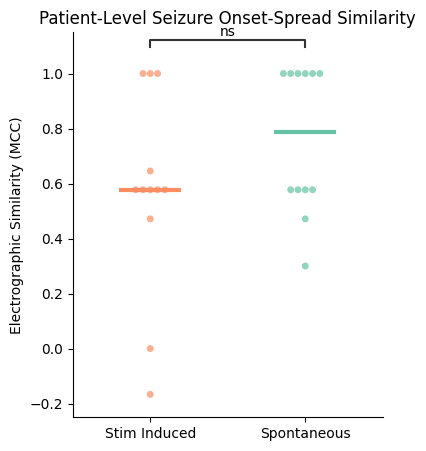

In [30]:
channel_onset_df = calculate_seizure_similarity(consensus_annots_rs,first_annot='ueo_consensus_rs',second_annot='sec_consensus_rs')
pal = sns.color_palette('Set2')[:2][::-1] + ['grey']
_ = plot_seizure_similarity(channel_onset_df,annot_type=' Onset-Spread',palette=pal,agreement='MCC',sz_level=False)

## Linear Modeling

## All annotations

### Creating consensus

In [7]:
annotators = np.sort(['EC','CK','DZ','JJ','JK']) # annotator list
time_labels = ['UEO_time'] # onset time label
clinician_tables = {}
for clin in annotators:
    # Load in secondary annotation push
    annot_table = pd.read_csv(ospj(metapath,f"stim_seizure_annotations_{clin}.csv"))
    # Load in annotations from initial assessment
    demo_table = pd.read_csv(ospj(metapath,f"stim_seizure_information - {clin}_annotation_demo.csv"))
    # Unifying onset column name
    demo_table.columns = [c if c != 'Onset' else 'approximate_onset' for c in demo_table.columns]
    
    # Load in additional annotations
    
    # Aggregating tables across clinicians and annotation sections
    clinician_tables[clin] = []
    clinician_tables[clin].append(annot_table)
    clinician_tables[clin].append(demo_table)
    if clin in ['EC','DZ']:
        new_table = pd.read_csv(ospj(metapath,f"stim_seizure_information - {clin}_makeup.csv"))
        new_table = new_table[["Patient","IEEGname","approximate_onset","end","stim","stim_channels","annotators","UEO_time","UEO_ch","10sec_ch"]]
        clinician_tables[clin].append(new_table)

# Organizing dataframes into a list for concatenation
df_list = [df for l in clinician_tables.values() for df in l]
# Getting annotator key for each DF
# key_list = np.array([[key]*len(clinician_tables[key]) for key in clinician_tables.keys()]).flatten()
key_list = np.array(list(itertools.chain.from_iterable([[key]*len(clinician_tables[key]) for key in clinician_tables.keys()])))

# Combining DFs
combined_df = pd.concat(df_list, keys=key_list, names=['Clinician'])

# Reset index to avoid having MultiIndex
combined_df.reset_index(inplace=True)

# Drop nan rows from csv loading
combined_df = combined_df.dropna(axis=0,how='any',subset=['UEO_ch'])

# Create a unique identifier for each seizure
combined_df['Seizure_ID'] = combined_df.groupby(['Patient', 'Clinician']).cumcount() + 1
combined_df['Seizure_ID'] = combined_df['Patient'] + '_' + combined_df['Seizure_ID'].astype(int).astype(str)
combined_df = combined_df.drop(['level_1'],axis=1)

# Turning strings of channels to a list
combined_df['UEO_ch'] = combined_df['UEO_ch'].str.split(',')
combined_df['10sec_ch'] = combined_df['10sec_ch'].str.split(',')

In [9]:
combined_tuning_annots = combined_df.groupby('Seizure_ID').apply(combine_ch_annots).reset_index()

In [10]:
combined_tuning_annots.to_pickle(ospj(prodatapath,'raw_combined_clinician_annotations.pkl'))

In [10]:
combined_tuning_annots = pd.read_pickle(ospj(prodatapath,'raw_combined_clinician_annotations.pkl'))

In [13]:
consensus_tuning_annots = combined_tuning_annots.apply(create_consensus,axis=1)
consensus_tuning_annots.patient.unique()

array(['CHOP005', 'CHOP010', 'CHOP015', 'CHOP024', 'CHOP026', 'CHOP028',
       'CHOP035', 'CHOP037', 'CHOP038', 'CHOP041', 'CHOP044', 'CHOP045',
       'CHOP046', 'CHOP049', 'HUP224', 'HUP225', 'HUP229', 'HUP230',
       'HUP235', 'HUP238', 'HUP246', 'HUP247', 'HUP249', 'HUP250',
       'HUP253', 'HUP257', 'HUP261', 'HUP263', 'HUP266', 'HUP267',
       'HUP273', 'HUP275', 'HUP288'], dtype=object)

In [13]:
consensus_tuning_annots.to_pickle(ospj(prodatapath,"threshold_tuning_consensus_v2.pkl"))